<h1> Google Colab Tutorial </h1>

Google Colab is an online enviornment for **Jupyter Notebooks**, a web-based interactive enviornment for running python code.  

Using Colab, you can write and run python code online, using your browser.  This makes your code easy to share, and because Colab uses Google's servers, it reduces the compatability issues caused by running your code on a different machine.

# Loading libraries in Colab

Most analyses will require specific libraries to run. Standard libraries are already installed in Colab, and you can uses the package installer *pip* to install anything that isn't available.   It is often helpful to import all the libraries you intend to use at the top of the notebook for clarity.

In [0]:
%matplotlib inline 
# this allows plots to be shown inline in the notebook

# Numpy is a standard computation library
import numpy as np

# useful plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# useful library for controlling dataframes.
import pandas as pd

# statistical libraries
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from sklearn import svm

Sometimes, a libary you need is not preinstalled.  You can use the package manager *pip* to install it before loading the libarary.  Here, we'll install and load "GPy" a Guassian Process toolkit: 

In [2]:
!pip install gpy
import GPy
print("GPy version: {}".format(GPy.__version__))

     |████████████████████████████████| 1.0MB 4.6MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2634006 sha256=e42c1db1e74afc2d938c4801788afd587842e800b2f83ff0c1df8ed3b609631b
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=32f75c73533f0f7afd1c979250f5a490df62e2c878cd5224d53b7470aabf0184
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz
GPy version: 1.9.9


You can also install custom libraries that are hosted on GitHub.  Here, We'll load a previously published computation computational model that's stored in GitHub.

In [3]:
!git clone https://github.com/nicktfranklin/SEM3.git
import os
os.chdir('./SEM3')
from core.sem import SEM
os.chdir('../')
print(SEM)

Cloning into 'SEM3'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 107 (delta 42), reused 92 (delta 35), pack-reused 0
Receiving objects: 100% (107/107), 18.01 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (42/42), done.


TensorFlow Version: 1.15.0
TensorFlow Check Passed
<class 'core.sem.SEM'>


# Analyses

In Colab, you can directly run your analyses and plot the results. This is useful for sharing, as you can set up a notebook to recreate all of the figures and analyses of some completed work.  This can also be useful to share with colaborators at earlier stages.

## Example 1: Independent t-test

In this first analysis, we'll create a toy data set consisting of a real-valued meaures broken up in two groups.

In [0]:
def fake_data_generator(means, stdevs, size=25):
    """
    This function creates a fake data set of two groups with a single, 
    real-valued measure. Each group's data is drawn from a normal distribution.

    :param means: list, the means of the two groups
    :param stdevs: list, the standard deviations of the two groups
    :param size: int (default=25), the number of samples per group

    :return x, y: list, list, the means of the two groups
    """
    x = np.random.normal(loc=means[0], scale=stdevs[0], size=size)
    y = np.random.normal(loc=means[1], scale=stdevs[1], size=size)

    return x, y


In [5]:
# set the parameters of the fake data
means = [5, 10]
stdevs  = [2, 4]
size = 25

# draw a random sample of fake data
x, y = fake_data_generator(means, stdevs, size)

# Store this in a Pandas DataFrame
my_data = pd.DataFrame({
    'Value': np.concatenate([x, y]),
    'Group': ['A'] * size + ['B'] * size
})

# Jupyter notebooks have a nice built in display for Pandas 
# dataframes.  Here, we show the first 5 rows.
my_data[:5]

,Value,Group
0,3.615611,A
1,3.220443,A
2,4.726221,A
3,8.956721,A
4,4.821405,A


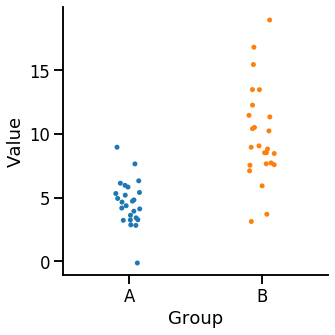

In [6]:
# use Seaborn's catplot function to plot the two groups' data
with sns.plotting_context('talk'):
  sns.catplot(x='Group', y='Value', data=my_data)
  plt.show()

In [0]:
# # how does sns.catplot work? Call the "help" function to see
# help(sns.catplot)

In [8]:
# run a statistical test on the two groups
print(ttest_ind(x, y))

Ttest_indResult(statistic=-6.401655175613628, pvalue=6.086804242834585e-08)


## Example 2: General linear model

In this example, we will again simulate a toy dataset and use a general linear model to analyze it

In [0]:
def fake_data_generator_linear_function(slopes, intercepts, stdevs, size=25,
                                        x_low=0, x_high=10):
    """
    This function creates a fake data set of two groups with a single
    real-valued dependent meaures and a single-real valued independent 
    meaures.  The data are generated via a linear function:

      y = m*x + b + epsilon

    where y is the dependent meaurse, x is the independent meaures, m is the
    slope, b is the intercept and epsilon is zero-mean Gaussian noise.

    for simplicity, we assume x is a sampled from a random uniform distribution 

    :param slopes: list, the slopes for each of the two groups
    :param intercepts: list, the intercepts for each of the two groups
    :param stdevs: list, the standard deviations of the two groups
    :param size: int (default=25), the number of samples per group

    :return x: np.array, the indpenent measures
    :return y: np.array, the dependent measures
    :return g: list of ints, group identities
    """
    # draw the independent measures from a uniform distribution
    x_a = np.random.uniform(low=x_low, high=x_high, size=size)
    x_b = np.random.uniform(low=x_low, high=x_high, size=size)

    # use the linear function to draw values of the dependent measures
    y_a = slopes[0] * x_a + intercepts[0] \
            + np.random.normal(loc=0, scale=stdevs[0], size=size)
    y_b = slopes[1] * x_b + intercepts[1] \
            + np.random.normal(loc=0, scale=stdevs[1], size=size)
    
    # concatenate the datasets
    x = np.concatenate([x_a, x_b])
    y = np.concatenate([y_a, y_b])
    g = ['A'] * size + ['B'] * size

    return x, y, g


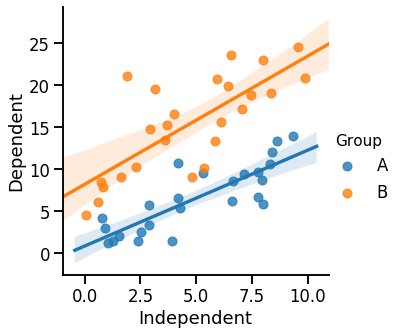

In [10]:
# set the parameters of the fake data
slopes = [1, 2.0]
intercepts = [1.0, 3.]
stdevs  = [2, 4]
size=25

# draw a random sample of fake data
args = [slopes, intercepts, stdevs, size]
x, y, g = fake_data_generator_linear_function(*args)

# Store this in a Pandas DataFrame
my_data = pd.DataFrame({
    'Dependent': y,
    'Independent': x,
    'Group': g,
 })


# use Seaborn's catplot function to plot the two groups' data
with sns.plotting_context('talk'):
  sns.lmplot(x="Independent", y="Dependent", hue="Group", data=my_data);
  plt.show()

In [11]:
mod = smf.ols(formula='Dependent ~ Independent * Group', data=my_data)
res = mod.fit()
print(res.summary2())

                  Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.768   
Dependent Variable:  Dependent         AIC:                 261.9466
Date:                2019-11-18 14:12  BIC:                 269.5947
No. Observations:    50                Log-Likelihood:      -126.97 
Df Model:            3                 F-statistic:         55.12   
Df Residuals:        46                Prob (F-statistic):  2.87e-15
R-squared:           0.782             Scale:               10.221  
--------------------------------------------------------------------
                       Coef.  Std.Err.   t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept              0.8324   1.3014 0.6397 0.5256 -1.7871  3.4519
Group[T.B]             7.3465   1.7941 4.0949 0.0002  3.7353 10.9577
Independent            1.1412   0.2270 5.0271 0.0000  0.6843  1.5982
Independent:Group[T.B] 0.3860   0.3204 1.2049 0.2344 

## Example 3: SVM

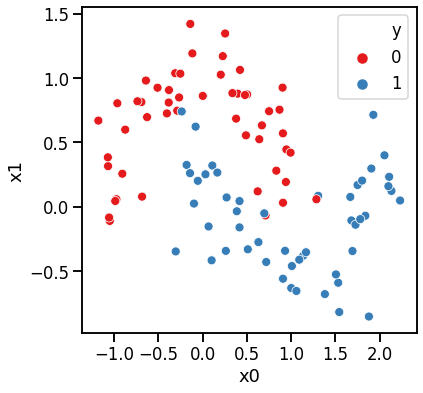

In [12]:
from sklearn.datasets import make_moons


X, y = make_moons(noise=0.2)
moons_dataframe = pd.DataFrame({
    'x0': X[:, 0],
    'x1': X[:, 1],
    'y': y,
})

with sns.plotting_context('talk'):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='x0', y='x1', hue='y', data=moons_dataframe, 
                    palette='Set1')

In [13]:
# fit a SVM model with an 
clf = svm.SVC(probability=True, kernel='rbf',
              C=2.0)
clf.fit(X, y)

 /usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning:The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

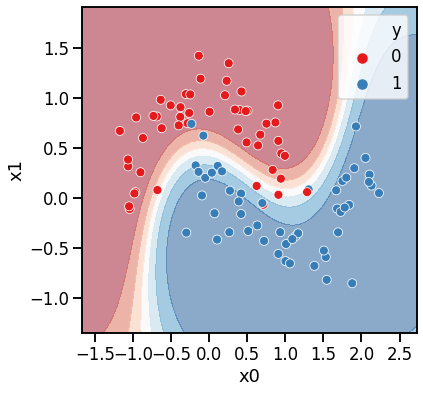

In [14]:
h = .02  # step size in the mesh

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
# fig, ax = plt.subplots()
cm = plt.cm.RdBu

with sns.plotting_context('talk'):
    plt.figure(figsize=(6,6))
    plt.gca().contourf(xx, yy, Z, cmap=cm, alpha=.5)
    sns.scatterplot(x='x0', y='x1', hue='y', data=moons_dataframe,
                    palette='Set1')
